<div class="alert alert-block alert-info">
Author:<br>Felix Gonzalez, P.E. <br> Adjunct Instructor, <br> Division of Professional Studies <br> Computer Science and Electrical Engineering <br> University of Maryland Baltimore County <br> fgonzale@umbc.edu
</div>

# Unsupervised Machine Learning and Clustering Algorithms: Customer Segmentation Example
This notebook provides an overview of unsupervised machine learning (ML), specifically clustering algorithms and a customer segmentation dataset. The dataset utilized can be found at: https://www.kaggle.com/datasets/datascientistanna/customers-dataset. 


# Table of Contents
[Python Libraries in this Notebook](#Python-Libraries-in-this-Notebook)

[Unsupervised Machine Learning: Customer Segmentation Analysis](#Unsupervised-Machine-Learning:-Customer-Segmentation-Analysis)

[](#)

[](#)

[](#)

[](#)

[](#)

[](#)

[](#)

[](#)

[](#)

[](#)

[](#)

[](#)

# Python Libraries in this Notebook
[Return to Table of Contents](#Table-of-Contents)

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1' # Resolves warning on KMeans memory leak.

#### Note on the above cell:
Note that on Windows computers you may get a memory leak warning. To solve this use the following solution: https://stackoverflow.com/questions/69596239/how-to-avoid-memory-leak-when-dealing-with-kmeans-for-example-in-this-code-i-am

A memory leak is a situation in computer science that occurs when a reseource that was initailly used by a computer is not being released by the system after it is not needed.

In [2]:
# imports
import pandas as pd
import numpy as np
from numpy import unique

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN # K-Means and DBSCAN algorithms
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score # Metrics 
from sklearn.neighbors import NearestNeighbors # Function to calculate distance to nearest neighbor points
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Scaling functions
from sklearn.datasets import make_blobs

# Defining Notebook Default Settings

In [3]:
pd.set_option('display.max_colwidth', None) # PD has a limit of 50 characters.  Removes limit and uses the full text.
pd.options.display.float_format = "{:.4f}".format # Sets PD to displays float numbers as 4 decimal places.
plt.style.use('tableau-colorblind10') # Sets MatPlotLib default color style to 'tableau-colorblind10'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Colors cycling.

# Unsupervised Machine Learning: Customer Segmentation Analysis
[Return to Table of Contents](#Table-of-Contents)

The goal of a customer segmentation analysis is to use clustering algorithms and be able to create clusters or groups of our customers. This groups are created using a selected number of features. Once the clusters are created the attributes and characteristics of these groups can be analyzed to create targeted advertisement, promotions, or other tasks that may be of interest to those specific groups.

# Data Loading

In [4]:
# Load data as dataframe.
# Data source: https://www.kaggle.com/datasets/datascientistanna/customers-dataset
df = pd.read_csv('./input_data/Customers.csv')

In [5]:
print(df.shape)
df.info()

(2000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB


In [6]:
df.sample(3)

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
1978,1979,Male,84,104589,85,Artist,10,2
13,14,Female,24,91000,77,Lawyer,1,1
78,79,Female,23,97000,52,Engineer,2,2


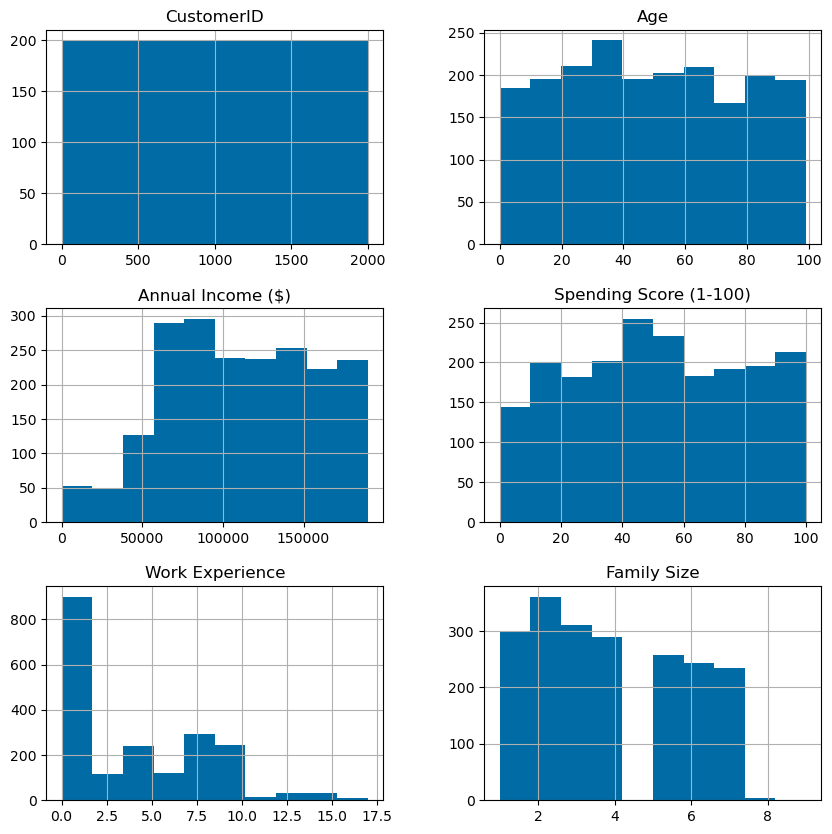

In [7]:
df.hist(figsize = [10, 10]);

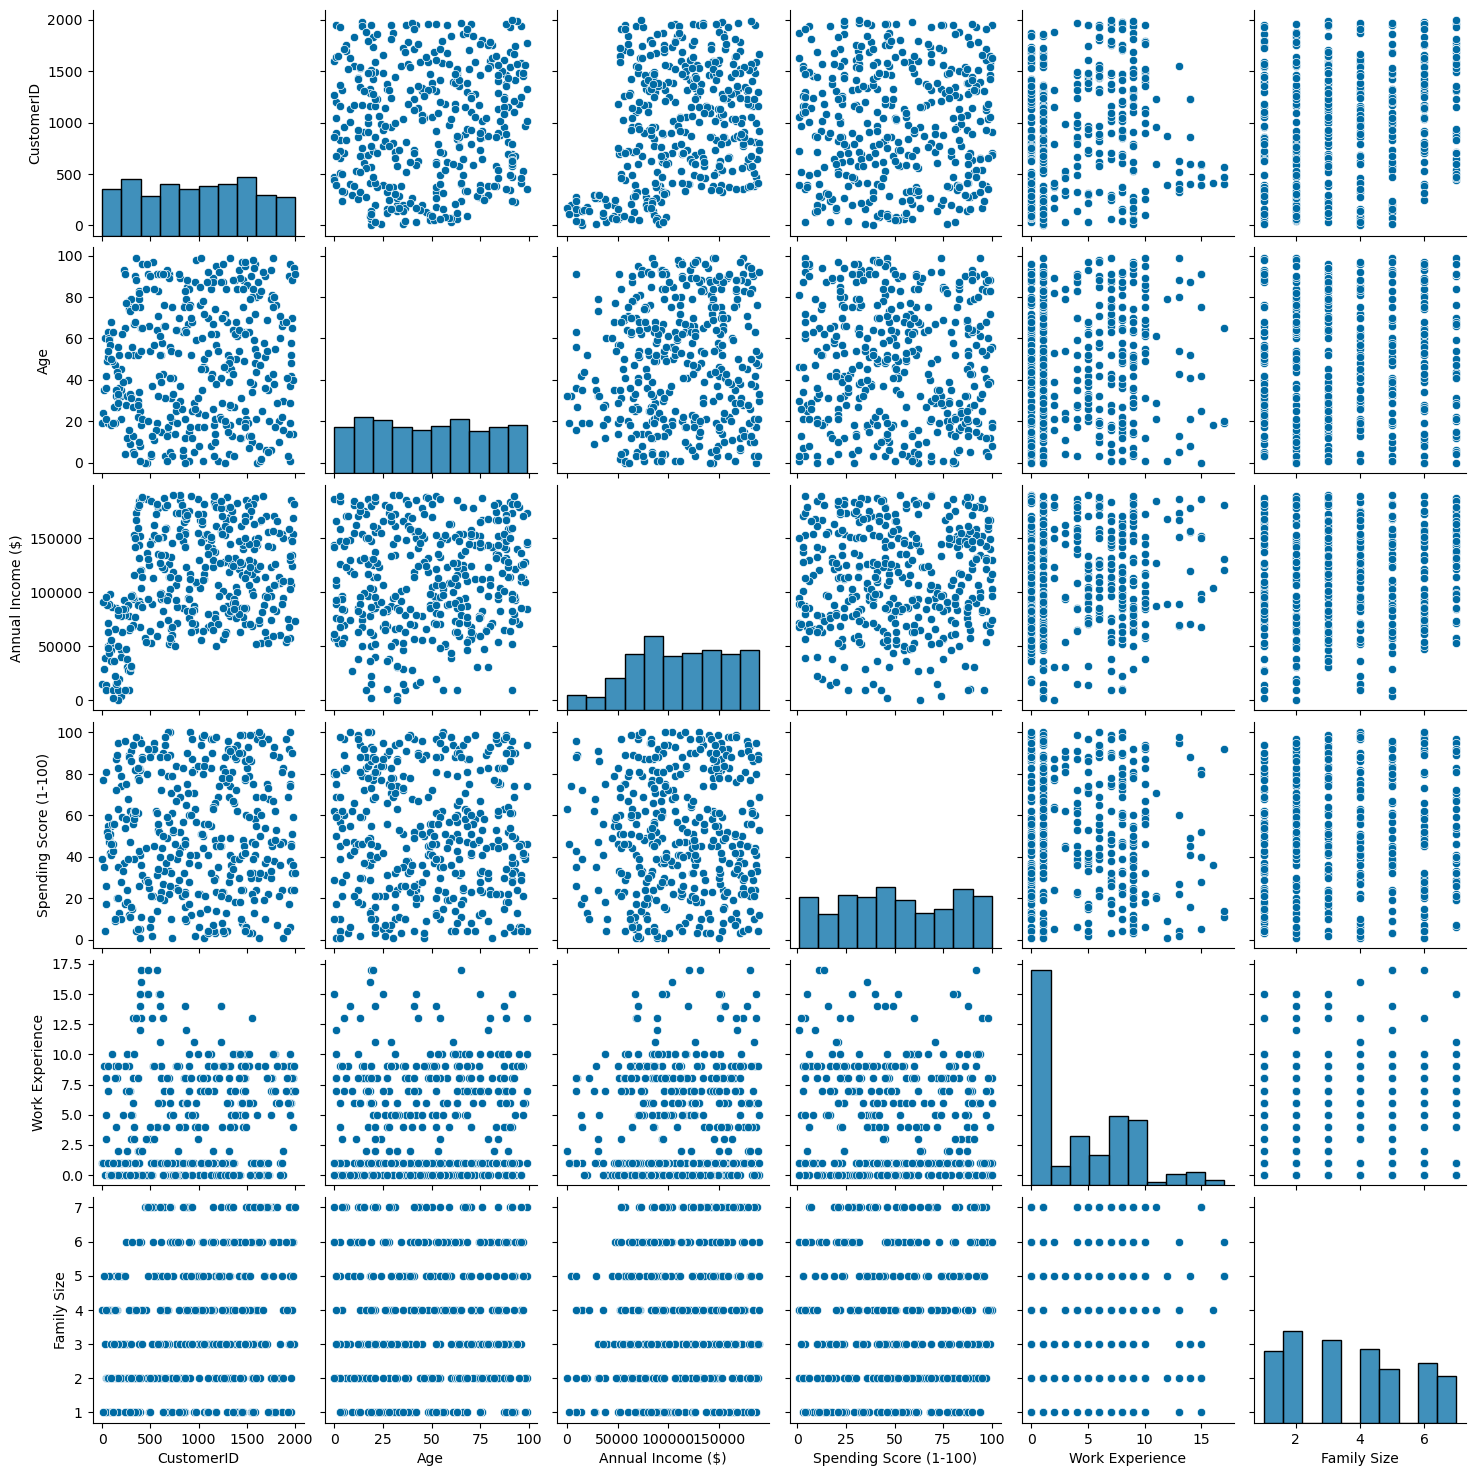

In [8]:
# SNS Pairplot Function
sns.pairplot(df.sample(400), 
             corner = False, 
             kind = 'scatter',
             height = 2.5);

Notes:
- Using the output from the SNS.pairplot() it is very difficult to identify trends or groups that we could separate the data.
- We could create bins based on annual income and spending scores something along these lines:
    - High annual income/low spending score
    - High annual income/high spending score
    - Low annual income/low spending score
    - Low annual income/high spending score
- Alternatively, using clustering algorithms and all the features such as Family size, age, annual income, spending score, and work experience may provide an easier and more mathematically optimal method. It would be expected that some clusters potentially have characteristics to other clusters identified in different ways but until we perform the clustering analysis we won't know for sure.

In [9]:
df.describe()

,CustomerID,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
count,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000
mean,1000.5000,48.9600,110731.8215,50.9625,4.1025,3.7685
std,577.4946,28.4297,45739.5367,27.9347,3.9222,1.9707
min,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000
25%,500.7500,25.0000,74572.0000,28.0000,1.0000,2.0000
50%,1000.5000,48.0000,110045.0000,50.0000,3.0000,4.0000
75%,1500.2500,73.0000,149092.7500,75.0000,7.0000,5.0000
max,2000.0000,99.0000,189974.0000,100.0000,17.0000,9.0000


In [20]:
df['Profession'].value_counts()

Profession
Artist           612
Healthcare       339
Entertainment    234
Engineer         179
Doctor           161
Executive        153
Lawyer           142
Marketing         85
Homemaker         60
Name: count, dtype: int64

Notes:
- Of all the columns, customer ID should not provide any insights as this is a unique ID for the customer. The rest of the columns may be used in the clustering algorithm as they may help provide some important clusters.
- Each Profession may also have different group statistics.

In [10]:
# Bins of Annual Income
df['Annual Income ($)'].value_counts(bins = [-np.inf, 50000, 100000, 150000, np.inf], sort = False, dropna = False) 

(-inf, 50000.0]         143
(50000.0, 100000.0]     739
(100000.0, 150000.0]    634
(150000.0, inf]         484
Name: count, dtype: int64

In [11]:
# Bins of spending score in our first group:
df[df['Annual Income ($)'] <= 50000]['Spending Score (1-100)'].value_counts(bins = [-np.inf, 25, 50, 75, 
                                                                                    np.inf], sort = False, dropna = False)

(-inf, 25.0]    31
(25.0, 50.0]    40
(50.0, 75.0]    41
(75.0, inf]     31
Name: count, dtype: int64

In [12]:
# Statistics for our first group of low annual income/low spending score 
df[(df['Annual Income ($)'] <= 50000) & (df['Spending Score (1-100)'] <= 25)].describe()

,CustomerID,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
count,31.0000,31.0000,31.0000,31.0000,31.0000,31.0000
mean,167.8387,46.8387,24709.6774,12.4194,2.5484,2.6129
std,83.4942,19.1974,14142.5918,6.0541,3.7313,1.6264
min,7.0000,12.0000,3000.0000,1.0000,0.0000,1.0000
25%,140.0000,36.0000,14000.0000,7.5000,0.0000,2.0000
50%,183.0000,46.0000,23000.0000,14.0000,1.0000,2.0000
75%,241.5000,58.5000,38000.0000,16.0000,3.5000,3.0000
max,263.0000,84.0000,50000.0000,24.0000,13.0000,9.0000


In [13]:
# Statistics for our group on high annual income/high spending score
df[(df['Annual Income ($)'] > 150000) & (df['Spending Score (1-100)'] > 75)].describe()

,CustomerID,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
count,120.0000,120.0000,120.0000,120.0000,120.0000,120.0000
mean,1121.2667,51.7083,168252.7917,87.4500,4.3083,3.7333
std,515.1157,30.6795,11413.4004,7.1265,3.9827,1.9650
min,301.0000,0.0000,150012.0000,76.0000,0.0000,1.0000
25%,649.7500,22.0000,158240.7500,81.0000,1.0000,2.0000
50%,1180.0000,51.5000,167395.0000,87.0000,3.0000,4.0000
75%,1556.2500,82.0000,177404.2500,93.2500,8.0000,6.0000
max,1994.0000,99.0000,189072.0000,100.0000,15.0000,7.0000


If we wanted to evaluate different group combinations we would need to create a loop that iterates through each of these bins/groups and extracts the statistics. For the two groups above we can see that the Age Work Experience and Family size are bigger for the second group.

A more optimal approach could also be to use clustering algorithms. We may still end up with some of the same clusters or more significant clusters but until the analysis is performed we wont' know.

# Clustering Analysis
[Return to Table of Contents](#Table-of-Contents)

The "30_Intro_Unsupervised_ML_Clustering.ipynb" Jupyter notebook explains in detail the theory and provides references on clustering algorithms. In this example, we will be using the customer data to create clusters. 

### Preparing Data for Clustering
[Return to Table of Contents](#Table-of-Contents)

The data input to a clustering algorithm requires the data to be an array-like. In many cases the results will be improved if the input data is also scaled. In this section we will scale the values in the df_data dataframe and extract the values as an array. Note that we can run all the functions in the EDA with the scaled data too or we can first scale the data and then run the EDA functions. We could have also done this step at the beginning when loading the data.

The customer segmentation dataset has various scales in its features as follows and may benefit from scaling:
- Gender: Male and Female values. Needs to be transformed to numeric where we rename the column to Male and use 1 for Male and 0 for Female.
- Age: 10E2
- Annual Income: 10E6
- Spending Score: 10E2
- Work Experience: 10E1
- Family Size: 10E1

In [14]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income ($)',
       'Spending Score (1-100)', 'Profession', 'Work Experience',
       'Family Size'],
      dtype='object')

#### Transforming Gender to Numerical

In [15]:
df['Gender'].value_counts(dropna = False) # This will need to be converted to numerical

Gender
Female    1186
Male       814
Name: count, dtype: int64

In [16]:
# Changin Gender values to 1s (for Male) and 0s (Female)
df['Gender'] = df['Gender'].replace({'Male':'1',
                                     'Female':'0'})
# Renaming column to Male
df.rename(columns={'Gender': 'Male'}, inplace=True)

In [17]:
df["Male"] = pd.to_numeric(df["Male"])

In [18]:
print(df[['Male']].dtypes)
df['Male'].value_counts(dropna = False) # This will need to be converted to numerical

Male    int64
dtype: object


Male
0    1186
1     814
Name: count, dtype: int64

In [23]:
features_to_use = ['Male', 'Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Work Experience', 'Family Size']

In [24]:
# Let's create a new dataframe that has the scaled data.
# Recall that there are various scaling methods.
df_data_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df[features_to_use].values), 
                              columns=df[features_to_use].columns, index=df.index)
df_data_scaled.head(5)

,Male,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
0,1.0000,0.1919,0.0790,0.3900,0.0588,0.3750
1,1.0000,0.2121,0.1842,0.8100,0.1765,0.2500
2,0.0000,0.2020,0.4527,0.0600,0.0588,0.0000
3,0.0000,0.2323,0.3106,0.7700,0.0000,0.1250
4,0.0000,0.3131,0.2000,0.4000,0.1176,0.6250


In [26]:
# Converting the values in the dataframe to an array which will be used as input to other functions.
df_scaled_array = df_data_scaled.to_numpy()
df_scaled_array

array([[1.        , 0.19191919, 0.07895817, 0.39      , 0.05882353,
        0.375     ],
       [1.        , 0.21212121, 0.18423574, 0.81      , 0.17647059,
        0.25      ],
       [0.        , 0.2020202 , 0.45269353, 0.06      , 0.05882353,
        0.        ],
       ...,
       [1.        , 0.87878788, 0.47880763, 0.14      , 0.52941176,
        0.125     ],
       [1.        , 0.77777778, 0.9585996 , 0.04      , 0.41176471,
        0.125     ],
       [1.        , 0.90909091, 0.58223757, 0.52      , 0.29411765,
        0.125     ]])

# K-Means Clustering Algorithm
[Return to Table of Contents](#Table-of-Contents)

### Optimal Number of Clusters
[Return to Table of Contents](#Table-of-Contents)

When using centroid based clustering algorithms one input that these algorithms require is for the user to define number of clusters. Even though the algorithms will accept any number of clusters to be calculated, an initial approach may be to calculate the optimal number of clusters. There are various mathematical methods to estimate the optimal number of clusters, two most common are:
- Elbow Method: Calculation of Cluster score and use the inflection (i.e., elbow) of the plot to decide the most optimal number of clusters.
- Silhoutte Coefficient Method: Calculatest the Silhoutte score and the number of clusters with the highest score is the most optimal number. 

In both methods the the algorithm iterates thru a specified number of expected clusters and calculates the score for each cluster which is then plotted. Note that if we will use the functions various times or deploy them it makes sense to create a  defined function with the code.

Note that on Windows computers you may get a memory leak warning. To solve this use the following solution: https://stackoverflow.com/questions/69596239/how-to-avoid-memory-leak-when-dealing-with-kmeans-for-example-in-this-code-i-am

In [27]:
# Code Calculates the Elbow Score and Silhoutte Coefficient to calculate the most optimal cluster number.


K = range(2, 21) # Defining the range of the minimum and maximum expected number of clusters.
km_scores= [] # Empty list for cluster scores.
km_silhouette = [] # Empty list for silhoutte scores.

for i in K: # Iterating from 2 to 10 clusters)
    km = KMeans(n_clusters=i, n_init = 'auto', random_state = 42).fit(df_scaled_array) # Calculating the Clusters in the df_scaled_array data.
    preds = km.predict(df_scaled_array) # Predicted clusters
    km_scores.append(-km.score(df_scaled_array)) # Use "-km.score" to calculate score and append to list of scores.
    
    silhouette = silhouette_score(df_scaled_array, preds) # Use "silhoutte_score" to calculate score 
    km_silhouette.append(silhouette) # Appends silhoutte score to list.

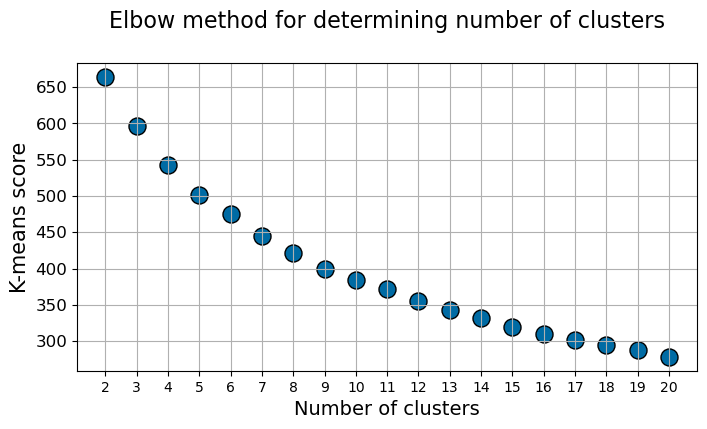

In [28]:
# Plot the Elbow using K-means score
plt.figure(figsize=(8,4))
plt.title("Elbow method for determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in K],y=km_scores,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in K],fontsize=10)
plt.yticks(fontsize=12)
plt.show()

Elbow method is more difficult to interpret as the elbow may not be well defined. In this casesomewhere between 3 and 8 clusters may be optimal, potentially around 5 clusters. Let's see the results of the Silhoutte Scores.

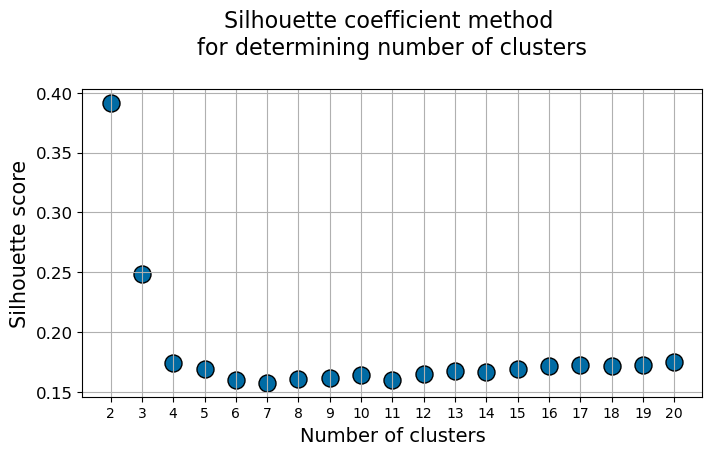

In [29]:
# Plot the Silhoutte Scores
plt.figure(figsize=(8,4))
plt.title("Silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in K],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in K],fontsize=10)
plt.yticks(fontsize=12)
plt.show()

The silhoutte method shows tha the optimal number of clusters is 2 clusters. However, 3 clusters could also be considered as both scores are larger than the rest. Going forward would make sense to run the Kmeans cluster using either 2, 3 or 5 clusters.

### Clustering with K-Means
[Return to Table of Contents](#Table-of-Contents)

In [31]:
# Kmeans
k = 3 # Test the outputs with 2, 3 and 6 clusters to see the effects.
kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state=0).fit(df_scaled_array)
cluster_pred = kmeans.labels_
centroids = kmeans.cluster_centers_

### Cluster Visualization
Because we have a total of 6 features or columns that we are using for the clustering it may not be easy to visualize. We will look at visualizations once clusters are assigned to the data. One approach is to use the sns.pairplot with hue = cluster label. The other approach may be to use PCA 2-dimension projection and use such plot for visualizing the clusters.

### Extracting KMeans Assigned Cluster Labels

In this section we will extract the labels of the calculated clusters. Note that the extracted cluster labels could be concatenated with the original dataset using the index. Recall that we need to excercise caution because if we had cleaned data (i.e., dropped) and not reset the index the dataframe of with the cluster labels and the one with the data will not match. 

In [33]:
df_cluster_label = pd.DataFrame(cluster_pred, columns=['kmeans_cluster_label']) # Creates a table with the cluster label.
# If for whatever reason you wanted to modify the clusters to start at 1 uncomment the line below.
df_cluster_label['kmeans_cluster_label'] += 1
# This modifies cluster "0" as cluster "1" and all other clusters up by 1.
df_cluster_label.head(5)

,kmeans_cluster_label
0,1
1,1
2,3
3,2
4,3


In [34]:
# Both dataframes should have the same number of rows.
print(df_cluster_label.shape)
print(df.shape)

(2000, 1)
(2000, 8)


In [35]:
# Applying the cluster_label as a column in the scaled dataframe.
# Note that we could also assign the label to the non-scaled dataframe too.
df['kmeans_cluster_label'] = df_cluster_label # Adding column with cluster_labels to the full dataset dataframe.
df.head(5)

,CustomerID,Male,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size,kmeans_cluster_label
0,1,1,19,15000,39,Healthcare,1,4,1
1,2,1,21,35000,81,Engineer,3,3,1
2,3,0,20,86000,6,Engineer,1,1,3
3,4,0,23,59000,77,Lawyer,0,2,2
4,5,0,31,38000,40,Entertainment,2,6,3


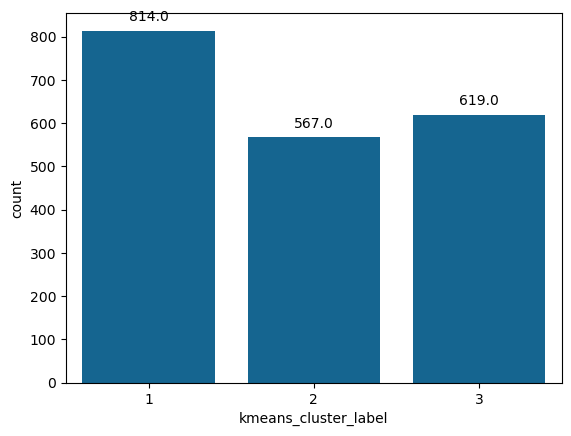

In [37]:
# We can calculate how many data points per each cluster.
cluster_count_figure = sns.countplot(x='kmeans_cluster_label', data = df)
for p in cluster_count_figure.patches:
    cluster_count_figure.annotate(format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()), 
                                  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [51]:
df.columns

Index(['CustomerID', 'Male', 'Age', 'Annual Income ($)',
       'Spending Score (1-100)', 'Profession', 'Work Experience',
       'Family Size', 'kmeans_cluster_label'],
      dtype='object')

In [60]:
# Using filtering we can get statistics for each group.
print(f'Statistics for full dataset:')
print(df.shape)
display(df[['Male', 'Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Work Experience', 'Family Size']].describe(percentiles = [0.5]))

for cluster_label in np.sort(df['kmeans_cluster_label'].unique()):
    print(f'Statistics for Cluster: {cluster_label}')
    display(df[(df['kmeans_cluster_label'] == cluster_label)].shape)
    display(df[(df['kmeans_cluster_label'] == cluster_label)][['Male', 'Age', 'Annual Income ($)', 'Spending Score (1-100)', 
            'Work Experience', 'Family Size']].describe(percentiles = [0.5]))
    display(df[(df['kmeans_cluster_label'] == cluster_label)]['Profession'].value_counts(dropna = False))

Statistics for full dataset:
(2000, 9)


,Male,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
count,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000,2000.0000
mean,0.4070,48.9600,110731.8215,50.9625,4.1025,3.7685
std,0.4914,28.4297,45739.5367,27.9347,3.9222,1.9707
min,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
50%,0.0000,48.0000,110045.0000,50.0000,3.0000,4.0000
max,1.0000,99.0000,189974.0000,100.0000,17.0000,9.0000


Statistics for Cluster: 1


(814, 9)

,Male,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
count,814.0000,814.0000,814.0000,814.0000,814.0000,814.0000
mean,1.0000,49.1597,110991.3231,50.9447,4.2002,3.7690
std,0.0000,28.6858,45555.9825,27.8086,3.9763,1.9636
min,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000
50%,1.0000,48.0000,108055.0000,51.0000,3.5000,4.0000
max,1.0000,99.0000,189945.0000,100.0000,17.0000,9.0000


Profession
Artist           232
Healthcare       143
Entertainment    101
Engineer          76
Doctor            72
Executive         66
Lawyer            56
Marketing         32
Homemaker         21
NaN               15
Name: count, dtype: int64

Statistics for Cluster: 2


(567, 9)

,Male,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
count,567.0000,567.0000,567.0000,567.0000,567.0000,567.0000
mean,0.0000,49.3616,115339.1429,75.7866,3.6861,3.8677
std,0.0000,28.7891,44770.3923,14.7375,3.7737,1.9513
min,0.0000,0.0000,1000.0000,47.0000,0.0000,1.0000
50%,0.0000,49.0000,117181.0000,76.0000,2.0000,4.0000
max,0.0000,99.0000,189630.0000,100.0000,17.0000,8.0000


Profession
Artist           180
Healthcare        98
Entertainment     69
Executive         47
Engineer          45
Doctor            43
Lawyer            39
Marketing         25
Homemaker         12
NaN                9
Name: count, dtype: int64

Statistics for Cluster: 3


(619, 9)

,Male,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size
count,619.0000,619.0000,619.0000,619.0000,619.0000,619.0000
mean,0.0000,48.3296,106170.2940,28.2472,4.3554,3.6769
std,0.0000,27.7884,46484.9652,15.0227,3.9601,1.9965
min,0.0000,0.0000,2000.0000,0.0000,0.0000,1.0000
50%,0.0000,47.0000,102543.0000,29.0000,4.0000,3.0000
max,0.0000,99.0000,189974.0000,56.0000,17.0000,8.0000


Profession
Artist           200
Healthcare        98
Entertainment     64
Engineer          58
Lawyer            47
Doctor            46
Executive         40
Marketing         28
Homemaker         27
NaN               11
Name: count, dtype: int64

Notes:
- Looks like the majority of the distribution of the features and means seems to be maintained the same as those found in the data. For example all professions seem to be represented and in similar ratios in all clusters. The age, annual icnomes, work experience and family size means for each cluster is very similar to those in the full dataset.
- The only exception is the spending score for which the full dataset mean is 51, for cluster 1 is 51, for clsuter 2 is 75, and Cluster 3 is 28.

Looks like when using the Kmeans algorithm spending score may have the highest impact in dividing and clustering the data. However, note that there is still overlap within the min/max values for each cluster. The cluster 1 min/max are 1 and 100 respectively. This means that some of the features did have an effect in assigning a cluster to those customers.

Now that we know this we can develop targeted promotions or advertisement based on statistics for each group of customers, most probably along spending scores. 

# DBSCAN Clustering Algorithm
[Return to Table of Contents](#Table-of-Contents)

DBSCAN is another commonly used clustering algorithms. It is a density based algorithm. Different to K-Means algorithm, the way the DBSCAN algorithm assigns a clusters is using a two parameters, density parameter called EPS or epsilon and a minimum sample of records in a cluster parameters called min_samples. The EPS value is a distance measure of how far a neighbor data point may be. If the data point closer than the EPS distance there is likelihood that they belong to the same cluster. The min_samples parameters defines the minimum number of neighbor data points before the algorithm assigns a cluster number.   

Once the two parameters are met the algorithm assigns clusters starting in 0. Clusters with assigned cluster number of -1 mean that the points did not meet either one or the two parameters. Datapoints in Cluster -1 are outliers to the parameters defined. This does not mean that they are statiscal outliers.

Depending on the values of the DBSCAN parameters, the following situations may occur:
- If the value of the EPS is too low or the min_samples in a cluster is too high, there may be a high likelihood that no set of datapoitns will be assigned a cluster and all of the datapoints are assigned cluster -1 and are considered outliers.
- If the value of the EPS is too high or the min_samples in a cluster is too low, there may be a high likelihood that all the datapoints will be assigned cluster 0 and belong to the same cluster.   
- In the optimal case, a good EPS value is selected and a good min_samples in a cluster is selected and the outputs provide useful clusters.

#### Optimal EPS
[Return to Table of Contents](#Table-of-Contents)

When using density based clustering algorithms one input that these algorithms require is for the user to define a density value. Even though the algorithms will accept any density value (e.g., EPS or Epsilon), the optimal value will produce the best results. In DBSCAN the most common method uses an Elbow method where the EPS is plotted against the number of samples. The inflection point can then be used to estimate the best EPS value.

Documentation References:
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
- https://www.kaggle.com/code/tanmaymane18/nearestneighbors-to-find-optimal-eps-in-dbscan
- https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

In [ ]:
# This code creates the data to determine the optimal density value (EPS). 
neigh = NearestNeighbors(n_neighbors=2) # Defines the model to calculate nearest neighbors.
nbrs = neigh.fit(df_scaled_array) # Fits the data to the model.
distances, indices = nbrs.kneighbors(df_scaled_array) # Calculates the distances
distances = np.sort(distances, axis=0) # Sorts the distances
distances = distances[:,1]

In [ ]:
# DataFrame for the "Samples vs. EPS", normalization/scaling and Optimal EPS.

# Creates a dataframe with the distances to be used in the plot.
df_eps_vs_samples = pd.DataFrame(distances, columns=['EPS'])
# Creates a column called "samples" for number of samples
df_eps_vs_samples['samples'] = df_eps_vs_samples.index

In [ ]:
df_eps_vs_samples.head(5) # Showing the dataframe of the EPS and Samples.

In [ ]:
# Plots for EPS vs. the number of samples
plt.plot(distances);
plt.xlabel("Samples", fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel("EPS", fontsize=14)
plt.yticks(fontsize=12)
plt.show();

# The optimal EPS will be at the elbow, knee, inflection or maximum curvature point.

The calculation of the optimal EPS can be automated by calculating the EPS at the inflection point or the elbow. There are libraries such as the [Kneed](https://pypi.org/project/kneed/) which can be used to obtain the point of maximum curvature. In this case we will estimate the inflection point visually.

In the case above the optimal EPS is approximately 0.03. However, it may be important to use trial and error with various EPS around this value to decide the best outputs.

### Clustering with DBSCAN
[Return to Table of Contents](#Table-of-Contents)

The code in this section uses DBSCAN algorithm to create the clusters and plot the data. As a user the two parameters that we need to define are the EPS and min_samples. A good approach would be to start with the optimal EPS and a min_samples of 5 or 10% of the total number of records. The code below also creates and colors the clusters and which of the data points and the cluster it belongs to.

In [ ]:
# DBSCAN clustering

EPS_value = 0.03 # Start with the estimated Optimal EPS value of 0.03.
# Test the outputs with 0.3 and 0.003.
min_samples_inacluster = 5 # Minimum number of points for creating a cluster.
# Test the outputs with 2, 10, 20, 100

# Define the model.  EPS is the max distance between points, and defines the density. 
cluster_pred = DBSCAN(eps= EPS_value, min_samples = min_samples_inacluster).fit_predict(df_scaled_array) 
clusters = unique(cluster_pred) # retrieve unique clusters
    
# Scatter plot
plt.figure(figsize=(8,8))
plt.scatter(df_scaled_array[:, 0], df_scaled_array[:, 1], 
            marker='o', s=30, lw=0, alpha=1, c=cluster_pred, cmap = 'Set1', edgecolor=None)
#plt.title(label = f"KMeans Clusters Plot.  Total Clusters = {clusters.max()} with EPS = {EPS_value}")
plt.xlabel("x-dimension (Scaled)", fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel("y-dimension (Scaled)", fontsize=18)
plt.yticks(fontsize=14)
plt.show()

When using the optimal EPS of 0.03 and a min_samples of 5 there seem to be 5 defined clusters with the red points being outliers. Let's confirm below.

#### Extracting DBSCAN Assigned Cluster Labels

In this section we will extract the labels of the calculated clusters. Note that the extracted cluster labels could be concatenated with the original dataset using the index. Recall that we need to excercise caution because if we had cleaned data (i.e., dropped) and not reset the index the dataframe of with the cluster labels and the one with the data will not match. 

In [ ]:
df_cluster_label = pd.DataFrame(cluster_pred, columns=['dbscan_cluster_label']) # Creates a new table with the cluster labels.

# If for whatever reason you wanted to modify the clusters to start at 1 uncomment the line below.
#df_cluster_label['dbscan_cluster_label'] += 1 
# This modifies cluster "0" as cluster "1" and all other clusters up.
# Note that this will change the number of the outliers cluster (i.e., Cluster -1) to Cluster 0.

df_cluster_label.head(5)

In [ ]:
# Applying the cluster_label as a column in the scaled dataframe.
df_cluster_label['dbscan_cluster_label'] = df_cluster_label # Adding column with cluster_labels to the full dataset dataframe.
df_cluster_label.head(5)

In [ ]:
cluster_count_figure = sns.countplot(x='dbscan_cluster_label', data = df_cluster_label)
for p in cluster_count_figure.patches:
    cluster_count_figure.annotate(format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
# Note that points in cluster 0 do not belong to any cluster. 

In [ ]:
# Same as before we can apply the cluster_label as a column in the scaled dataframe.
# Note that we could also assign the label to the non-scaled dataframe too.
df_data['dbscan_cluster_label'] = df_cluster_label # Adding column with cluster_labels to the full dataset dataframe.
df_data.head(5)

In majority of the use cases, when deploying a Clustering model we would only use the results of one of the clustering algorithms. The above dataframe with the kmeans_cluster_label and the dbscan_cluster_label feature allows to compare the results if you wanted to do such.

# Concluding Remarks
[Return to Table of Contents](#Table-of-Contents)

Clustering algorithms such as Kmeans and DBSCAN can be used to group and cluster datapoints based on specific features. Both resulted in different clusters and you need to be aware of the geometry of your data to determine the best clustering algorithm. 
Implementation of other clustering algorithms would be similar to the process above.

For example, we have a customer segmentation problem and we have customer data on the household income and household spending. The data of these two features can be used to cluster and create groups of customers. The groups can then be analyzed individually to develop targeted ads that would be of more interest to the specific customers groups. Potentially these groups may look like, high income/high spending, low income/low spending, low income/high spending and high income/low spending. The final characteristics of the clusters or groups will depend on the algorithm and the parameters used.   

# Notebook End